# PRE-PROCESSING DEVICE STATUS DATA

In [1]:
import os
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql.functions import split
from pyspark import SparkContext
from pyspark.sql import SQLContext
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import geoplot
import re
import boto3
from io import StringIO

In [2]:
sc = SparkContext("local", "First App")
sqlContext = SQLContext(sc)

In [12]:
#getting data from S3
s3 = boto3.resource('s3')
bucket = s3.Bucket('geo-clustering')
obj = bucket.Object(key='devicestatus.txt')
response = obj.get()
lines = response[u'Body'].read().split(b'\n')
raw_data=[]
for line in lines:
     raw_data.append(str(line, 'utf-8'))
x=raw_data.pop()
print(len(lines))

100001


In [4]:
#creating a pyspark data frame after extracting columns
raw_rdd = sc.parallelize(raw_data)
split_rdd=raw_rdd.map(lambda line: re.split(',|\||/',line))
device_status_raw_split=split_rdd.toDF()

In [5]:
#Selecting only required fields for this project
required_fields_df=device_status_raw_split.select("_1","_2","_3","_13","_14")

In [6]:
#Removing longitudes and latitides with 0 magnitude
required_fields_df_with_no_zero_lat = required_fields_df.filter(required_fields_df._13 != 0)

In [7]:
#Seperating manufacturer name and model name from the 2nd column
extracted_manu_model_name=required_fields_df_with_no_zero_lat. \
withColumn("manufacturer",split(required_fields_df_with_no_zero_lat._2," ").getItem(0)). \
withColumn("model",split(required_fields_df_with_no_zero_lat._2," ").getItem(1))

In [8]:
#Renaming the modified columns to get our final data
final_device_data=extracted_manu_model_name.drop(extracted_manu_model_name._2).\
withColumnRenamed("_1","date").\
withColumnRenamed("_3","deviceId").\
withColumnRenamed("_13","latitute").\
withColumnRenamed("_14","longitude")


###  VISUALIZATION USING GEOPANDAS

In [9]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import geoplot

In [10]:
#extracting only latitude and longitude and converting to double type to plot
final_device_data=final_device_data.drop("date","deviceId","manufacturer","model")
final_device_data=final_device_data.withColumn('latitute',final_device_data['latitute'].cast(DoubleType())).withColumn('longitude',final_device_data['longitude'].cast(DoubleType())).cache()
final_device_data_pd=final_device_data.toPandas()

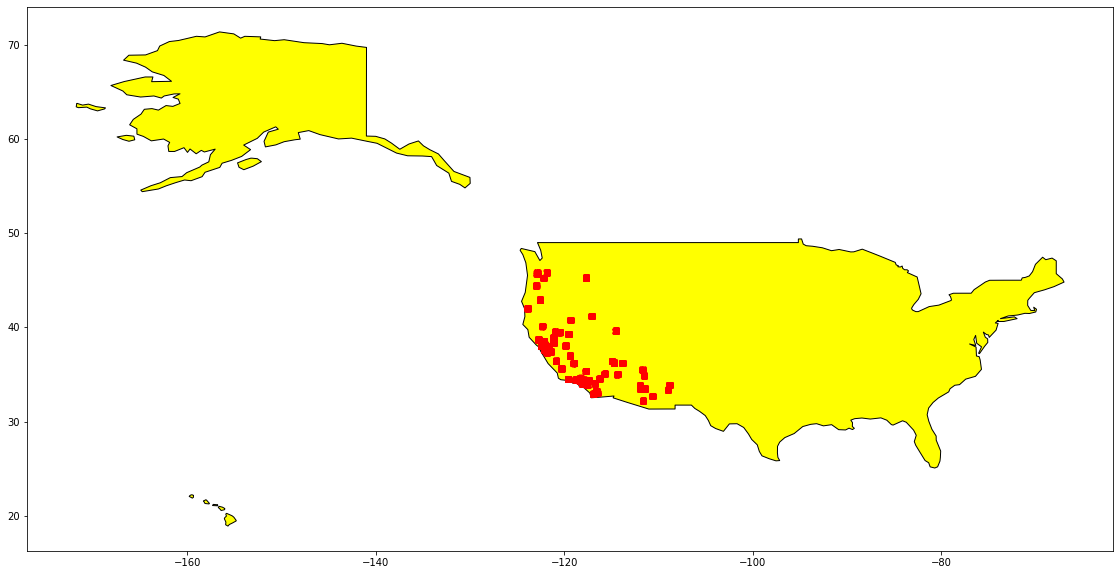

In [11]:
#Plotting the latitudes and longitude
geometry = [Point(xy) for xy in zip(final_device_data_pd['longitude'], final_device_data_pd['latitute'])]
gdf = GeoDataFrame(final_device_data_pd, geometry=geometry)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax=world[world.name == 'United States of America'].plot(color='yellow', edgecolor='black',figsize=(20, 10))
gdf.plot(ax=ax, marker='o', color='red', markersize=1);

In [27]:
#Saving the processed data onto s3
csv_buffer = StringIO()
final_device_data_pd.to_csv(csv_buffer, sep="|", index=False)
s3.Object("geo-clustering", "devicestatusprocessed.csv").put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'FB384F50E88F95C3',
  'HostId': 'rcl947K/YRZ9o79wLWMNNr7rUIJLphSqKlSQ7abkxeUKFe5oGVygvax3O9x+/2BSz9WC5xS1GGo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'rcl947K/YRZ9o79wLWMNNr7rUIJLphSqKlSQ7abkxeUKFe5oGVygvax3O9x+/2BSz9WC5xS1GGo=',
   'x-amz-request-id': 'FB384F50E88F95C3',
   'date': 'Fri, 27 Nov 2020 01:47:32 GMT',
   'etag': '"b7bb0c84ac6bf29a1f002da727328b4e"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"b7bb0c84ac6bf29a1f002da727328b4e"'}